#### Imports

In [1]:
import numpy as np
import mdtraj as md
import os

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 24
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes\n",
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title\n",
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels\n",
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize\n",
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title"

In [3]:
default_color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

#### Read works from the following relative paths

```
complex_1_steps/new.works.npy
complex_1_steps/old.works.npy
complex_500_steps/new.works.npy
complex_500_steps/old.works.npy
solvent_1_steps/new.works.npy
solvent_1_steps/old.works.npy
solvent_500_steps/new.works.npy
solvent_500_steps/old.works.npy
```

and save the results in a dictionary

In [4]:
works_dict = {}
paths = []
for phase in ['solvent', 'complex']:
    for side in ['new', 'old']:
        for steps in [1, 500]:
            try:
                path = f"{phase}_{steps}_steps/{side}.works.npy"
                paths.append(path)
                detail = np.load(path, allow_pickle=True)
                works_dict[f'{phase}.{steps}.{side}'] = detail.item()
            except Exception as e:
                print(e)

[Errno 2] No such file or directory: 'solvent_1_steps/old.works.npy'


it looks like i failed to save the old solvent works properly; no matter

In [5]:
for path in sorted(paths):
    print(path)

complex_1_steps/new.works.npy
complex_1_steps/old.works.npy
complex_500_steps/new.works.npy
complex_500_steps/old.works.npy
solvent_1_steps/new.works.npy
solvent_1_steps/old.works.npy
solvent_500_steps/new.works.npy
solvent_500_steps/old.works.npy


#### What keys does this dictionary have?

In [6]:
works_dict.keys()

dict_keys(['solvent.1.new', 'solvent.500.new', 'solvent.500.old', 'complex.1.new', 'complex.500.new', 'complex.1.old', 'complex.500.old'])

In [7]:
works_dict['solvent.500.old'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

#### What do these work trajectories look like?

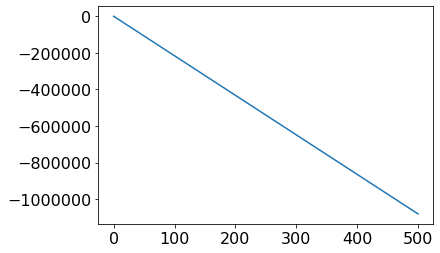

In [8]:
plt.plot(works_dict['solvent.500.old'][0])

In [9]:
type(works_dict['solvent.500.old'][0])

list

Text(0, 0.5, '$\\Delta u/ \\Delta step$ $[kT]$')

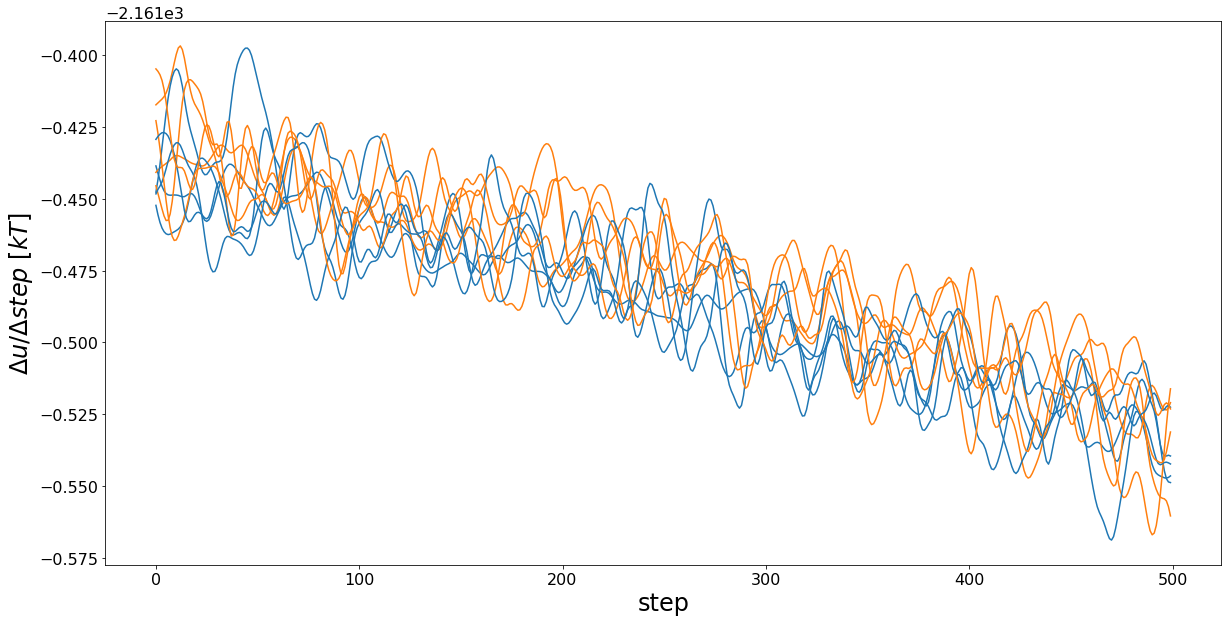

In [10]:
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(nrows=1, ncols=1)
for i in range(5):
    plt.plot(np.diff(works_dict['solvent.500.new'][i]), color = default_color_cycle[0])
    plt.plot(np.diff(works_dict['complex.500.new'][i]), color = default_color_cycle[1])
plt.xlabel(f"step")
plt.ylabel("$\Delta u/ \Delta step$ $[kT]$")

#### Let's replace the inner nested dictionaries with a dictionary whose values are arrays

`works_dict` has `{'solvent.500.old' : work_dict}` pairs. Let's unpack each `work_dict`.

In [11]:
def work_array_from_inner_work_dict(inner_work_dict):
    """assume work_dict has { key : accumulated_work_array } pairs
    
    assume each accumulated_work_array has the same length
    
    return an array of shape (len(work_dict), len(accumulated_work_array))
    """
    
    keys = sorted(list(inner_work_dict.keys()))
    work_array = np.zeros((len(keys), len(inner_work_dict[keys[0]])))
    for i, key in enumerate(keys):
        work_array[i] = np.array(inner_work_dict[key])
    return work_array

In [12]:
work_arrays = dict()
for key in works_dict:
    work_arrays[key] = work_array_from_inner_work_dict(works_dict[key])

    print('{}:\n\t{}'.format(key, work_arrays[key].shape))

solvent.1.new:
	(100, 2)
solvent.500.new:
	(100, 501)
solvent.500.old:
	(100, 501)
complex.1.new:
	(100, 2)
complex.500.new:
	(100, 501)
complex.1.old:
	(100, 2)
complex.500.old:
	(100, 501)


#### Let's look at work standard deviations

In [13]:
def final_work_stddev(work_array):
    return np.std(work_array, 0)[-1]

for key in work_arrays:
    print('{}:\n\t{:.4f}'.format(key, final_work_stddev(work_arrays[key])))

solvent.1.new:
	8.2076
solvent.500.new:
	3.4142
solvent.500.old:
	3.3491
complex.1.new:
	8.4938
complex.500.new:
	2.4660
complex.1.old:
	7.9462
complex.500.old:
	1.8952


#### Let's look at the work stddev time-series

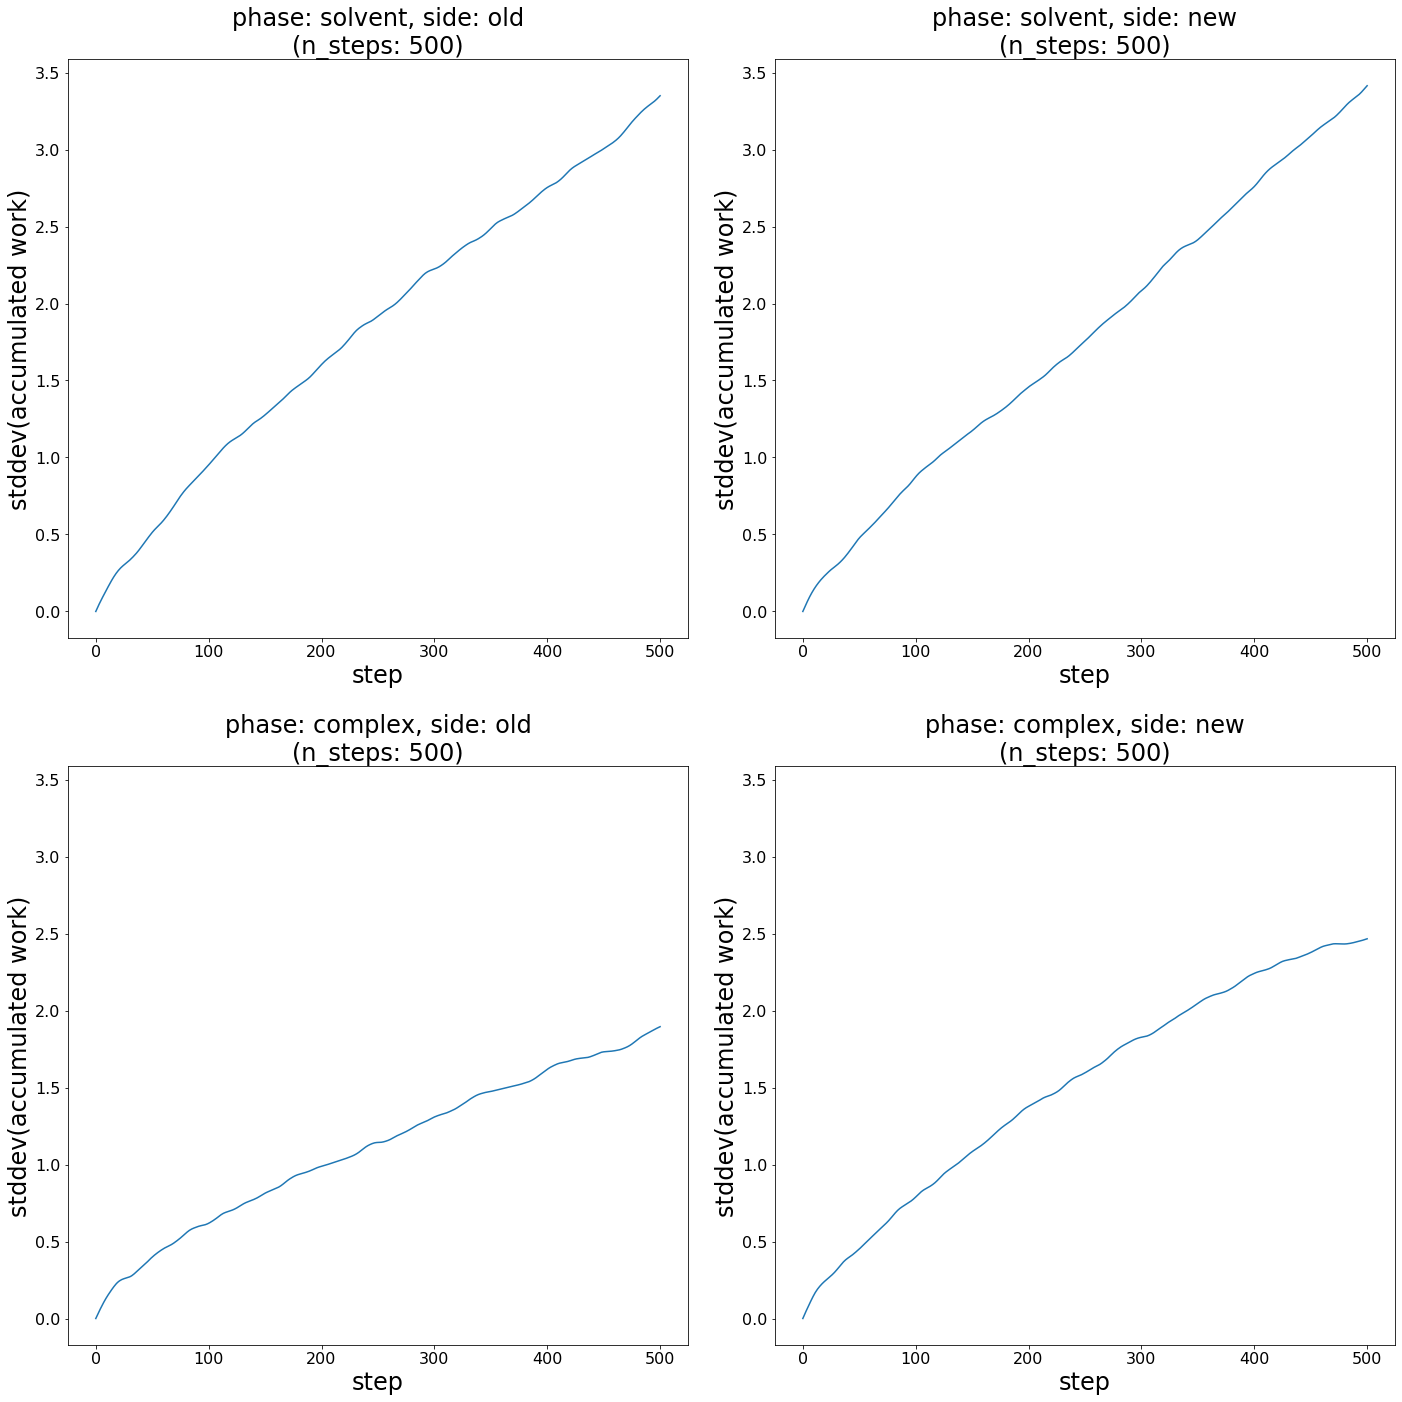

In [15]:
ind = 1; ax = None
n_steps = 500
plt.figure(figsize=(20,20))
for phase in ['solvent', 'complex']:
    for side in ['old', 'new']:
        key = f'{phase}.{n_steps}.{side}'
        w_stddev = work_arrays[key].std(0)
        
        ax = plt.subplot(2,2,ind, sharey=ax)
        ind += 1

        plt.plot(w_stddev)
        title = f'phase: {phase}, side: {side}\n(n_steps: {n_steps})'
        plt.title(title)
        plt.xlabel('step')
        plt.ylabel('stddev(accumulated work)')
plt.tight_layout()

#### Err, all on one plot

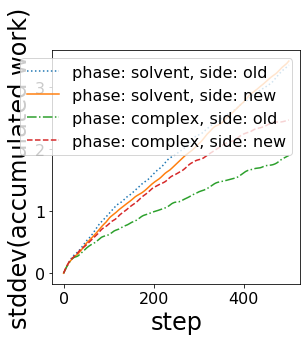

In [16]:
plt.figure(figsize=(5,5))

phases = ['solvent', 'complex']
sides = ['old', 'new']
markers = {'solvent': 'o', 'complex': 'triangle'}
linestyles =  {
    ('solvent', 'new'): 'solid',
    ('complex', 'new'): 'dashed',
    ('solvent', 'old'): 'dotted',
    ('complex', 'old'): 'dashdot',
}


for phase in phases:
    for side in sides:
        key = f'{phase}.{n_steps}.{side}'
        w_stddev = work_arrays[key].std(0)
        
        label = f'phase: {phase}, side: {side}'
        plt.plot(w_stddev, label=label, linestyle=linestyles[(phase, side)])

plt.xlabel('step')
plt.ylabel('stddev(accumulated work)')
plt.legend()
plt.tight_layout()

#### Histograms of final works

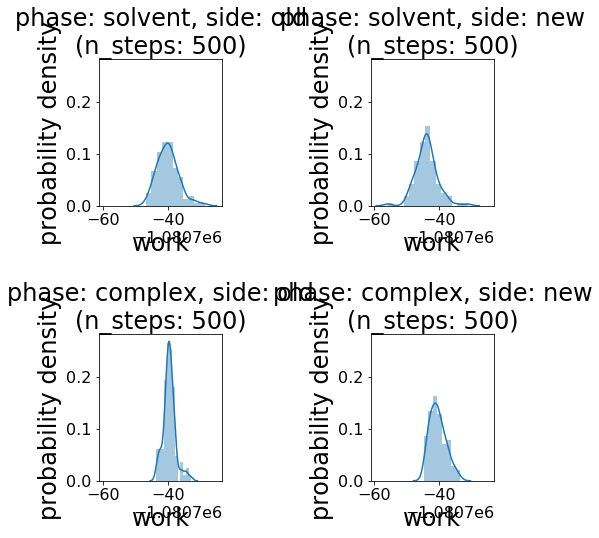

In [17]:
ind = 1; ax = None
n_steps = 500
plt.figure(figsize=(8,8))

dfs = {}

for phase in ['solvent', 'complex']:
    for side in ['old', 'new']:
        # extract final works
        key = f'{phase}.{n_steps}.{side}'
        final_works = work_arrays[key][:,-1]
        
        # set up axes, in particular sharing x-axis limits with other subplots
        ax = plt.subplot(2,2,ind, sharex=ax, sharey=ax)
        ind += 1

        # plot histogram and kde
        sns.distplot(final_works)
        
        
        title = f'phase: {phase}, side: {side}\n(n_steps: {n_steps})'
        plt.title(title)
        plt.xlabel('work')
        plt.ylabel('probability density')
        
        
        ## add a textbox for EXP estimates
        #from pymbar import EXP
        #df, ddf = EXP(final_works)
        #dfs[key] = df
        #textstr='EXP(w) : {:.3f}'.format(df) + r'$\pm$' + '{:.3f}'.format(ddf)
        #textbox_props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
        #ax.text(
        #    0.05, 0.95, textstr,
        #    transform=ax.transAxes, fontsize=10,
        #    verticalalignment='top', bbox=textbox_props
        #)
plt.tight_layout()

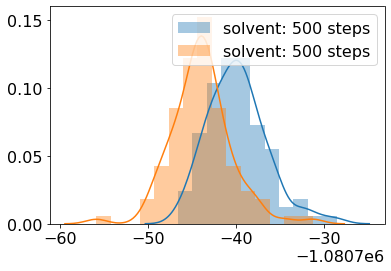

In [18]:
#sns.distplot([val[-1] for val in works_dict['solvent.1.old'].values()], label = f'solvent: instantaneous')
sns.distplot([val[-1] for val in works_dict['solvent.500.old'].values()], label = f'solvent: 500 steps')
sns.distplot([val[-1] for val in works_dict['solvent.500.new'].values()], label = f'solvent: 500 steps')
plt.legend()

#### Let's compare with corresponding instantaneous work distribution for each condition

'solvent.1.old'
had a problem with solvent.1.old


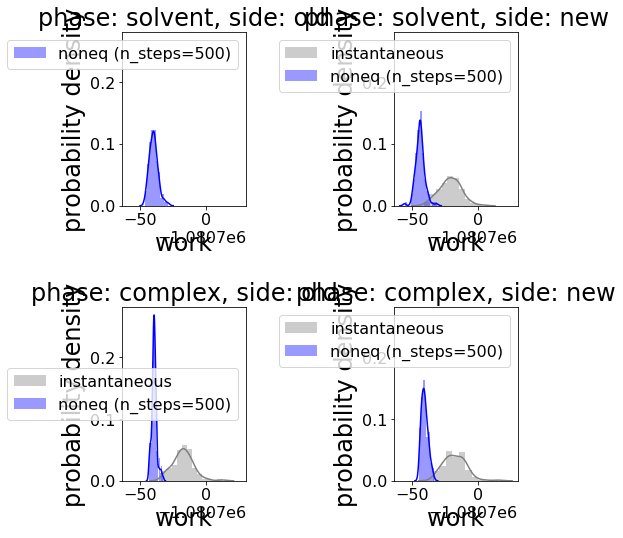

In [19]:
ind = 1; ax = None
n_steps = 500
plt.figure(figsize=(8,8))

inst_color = 'grey'
noneq_color = 'blue'

for phase in ['solvent', 'complex']:
    for side in ['old', 'new']:
        ax = plt.subplot(2,2,ind, sharex=ax, sharey=ax)
        ind += 1
        
        inst_key = f'{phase}.1.{side}'
        noneq_key = f'{phase}.{n_steps}.{side}'
        
        # hmm, missing one
        try:
            inst_works = work_arrays[inst_key][:,-1]
            sns.distplot(inst_works, label='instantaneous', color=inst_color)
        except Exception as e:
            print(e)
            print(f'had a problem with {inst_key}')
        
        noneq_works = work_arrays[noneq_key][:,-1]
        sns.distplot(noneq_works, label=f'noneq (n_steps={n_steps})', color=noneq_color)
        
        title = f'phase: {phase}, side: {side}'
        
        plt.legend()
        plt.title(title)
        plt.xlabel('work')
        plt.ylabel('probability density')
plt.tight_layout()

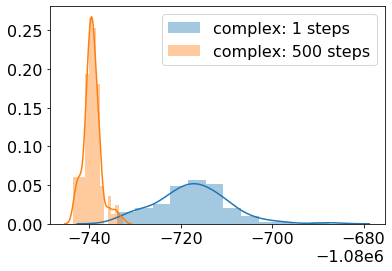

In [20]:
#sns.distplot([val[-1] for val in works_dict['complex.1.old'].values()], label = 'complex: instantaneous')
sns.distplot([val[-1] for val in works_dict['complex.1.old'].values()], label = 'complex: 1 steps')
sns.distplot([val[-1] for val in works_dict['complex.500.old'].values()], label = 'complex: 500 steps')
plt.legend()

#### Computing EXP and BAR estimates for each leg

#### Computing endpoint correction

i am going to spell out how the free energy correction should be done. 
We know that the relative free energy of 'ligXtoY' is measured as dg_X - dg_Y; 
we also know that RT = 0.593 kcal/mol at 298K; <br>
first, let's plot the perses vs experimental results

In [21]:
perses_dgs = np.load('perses_calc_dgs.npy', allow_pickle=True).item()
experimental_dgs = np.load('exp_calc_dgs.npy', allow_pickle=True).item()
assert set(list(perses_dgs.keys())) == set(list(experimental_dgs.keys()))

Text(0, 0.5, '$\\Delta G_{calculation, MM}$ $[kcal/mol]$')

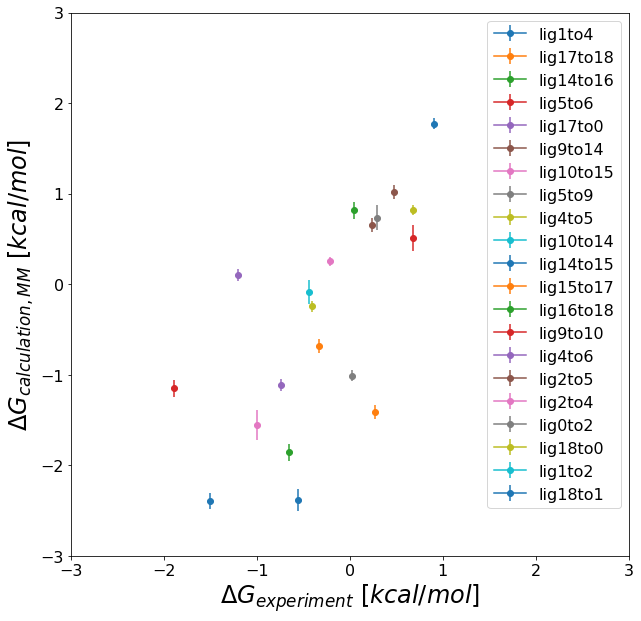

In [27]:
fig = plt.figure(figsize=(10, 10))
for key in perses_dgs.keys():
    plt.errorbar(experimental_dgs[key], perses_dgs[key][0], yerr = perses_dgs[key][1], label = f"lig{key[0]}to{key[1]}", marker = 'o')
plt.legend()
#slope, intercept, rval, pval, stderr = linregress(calcs, perses)
#space = np.linspace(min(calcs), max(calcs), 100)
#plt.plot(space, space*slope + intercept)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('$\Delta G_{experiment}$ $[kcal/mol]$')
plt.ylabel('$\Delta G_{calculation, MM}$ $[kcal/mol]$')

since we have $\Delta G_{MM} = \Delta G_{1, MM} - \Delta G_{2, MM}$, we can say that $\Delta G_{1, ANI} - \Delta G_{2, ANI} =  \Delta G_{MM}  + \left(  \Delta G_{complex, old} - \Delta G_{solvent, old}\right) - \left(  \Delta G_{complex, new} - \Delta G_{solvent, new} \right)$

In [28]:
from pymbar import EXP
dg_complex_old, ddg_complex_old = EXP(np.array([val[-1] for val in works_dict['complex.500.old'].values()]))
dg_complex_new, ddg_complex_new = EXP(np.array([val[-1] for val in works_dict['complex.500.new'].values()]))
dg_solvent_old, ddg_solvent_old = EXP(np.array([val[-1] for val in works_dict['solvent.500.old'].values()]))
dg_solvent_new, ddg_solvent_new = EXP(np.array([val[-1] for val in works_dict['solvent.500.new'].values()]))

In [ ]:
ddg_complex_old

In [ ]:
ddg_solvent_old

In [ ]:
dg_complex_new -dg_complex_old

In [ ]:
(dg_complex_old - dg_solvent_old)/0.593

In [ ]:
(dg_complex_new - dg_solvent_new)/0.593

In [ ]:
binding_dg = perses_dgs[(0,2)][0]
ani_binding_dg = binding_dg + (dg_complex_old - dg_solvent_old)/0.593 - (dg_complex_new - dg_solvent_new)/0.593

In [ ]:
ani_binding_dg

In [ ]:
ani_error = np.sqrt(perses_dgs[(0,2)][1]**2 + (ddg_solvent_old/0.593)**2 + (ddg_solvent_new/0.593)**2 + (ddg_complex_old/0.593)**2 + (ddg_complex_new/0.593)**2)

In [ ]:
ani_error

In [ ]:
experimental_dgs[(0,2)]

todo:
1. check ani forces
2. check thermocycle and free energy correction

In [29]:
half_data_path = 'home/rufad/'
transforms = os.listdir(half_data_path)
#/mnt/c/Users/domin/github/nn-endstates/round_1_data/home/rufad/lig0to2/wrapper/solvent_1000_steps

grand_works_dict = {}
for transform in transforms:
    print(transform)
    _interim_dict = {}
    for phase in ['solvent', 'complex']:
        for side in ['new', 'old']:
            for steps in [1000]:
                try:
                    _path = os.path.join(os.getcwd(), f"home/rufad/{transform}/wrapper/{phase}_{steps}_steps/{side}.works.npy")
                    #print(_path)
                    detail = np.load(_path, allow_pickle=True)
                    _interim_dict[f'{phase}.{steps}.{side}'] = detail.item()
                except Exception as e:
                    print(e)
    grand_works_dict[transform] = _interim_dict
                

lig0to2
lig10to14
lig10to15
[Errno 2] No such file or directory: '/mnt/c/Users/domin/github/nn-endstates/round_1_data/home/rufad/lig10to15/wrapper/solvent_1000_steps/old.works.npy'
lig14to15
lig14to16
lig15to17
lig16to18
[Errno 2] No such file or directory: '/mnt/c/Users/domin/github/nn-endstates/round_1_data/home/rufad/lig16to18/wrapper/solvent_1000_steps/new.works.npy'
lig17to0
[Errno 2] No such file or directory: '/mnt/c/Users/domin/github/nn-endstates/round_1_data/home/rufad/lig17to0/wrapper/solvent_1000_steps/old.works.npy'
lig17to18
lig18to0
lig18to1
lig1to2
lig1to4


[0, 2]
[10, 14]
'solvent.1000.old'
[10, 15]
[14, 15]
[14, 16]
[15, 17]
'solvent.1000.new'
[16, 18]
'solvent.1000.old'
[17, 0]
[17, 18]
[18, 0]
[18, 1]
[1, 2]
[1, 4]


/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


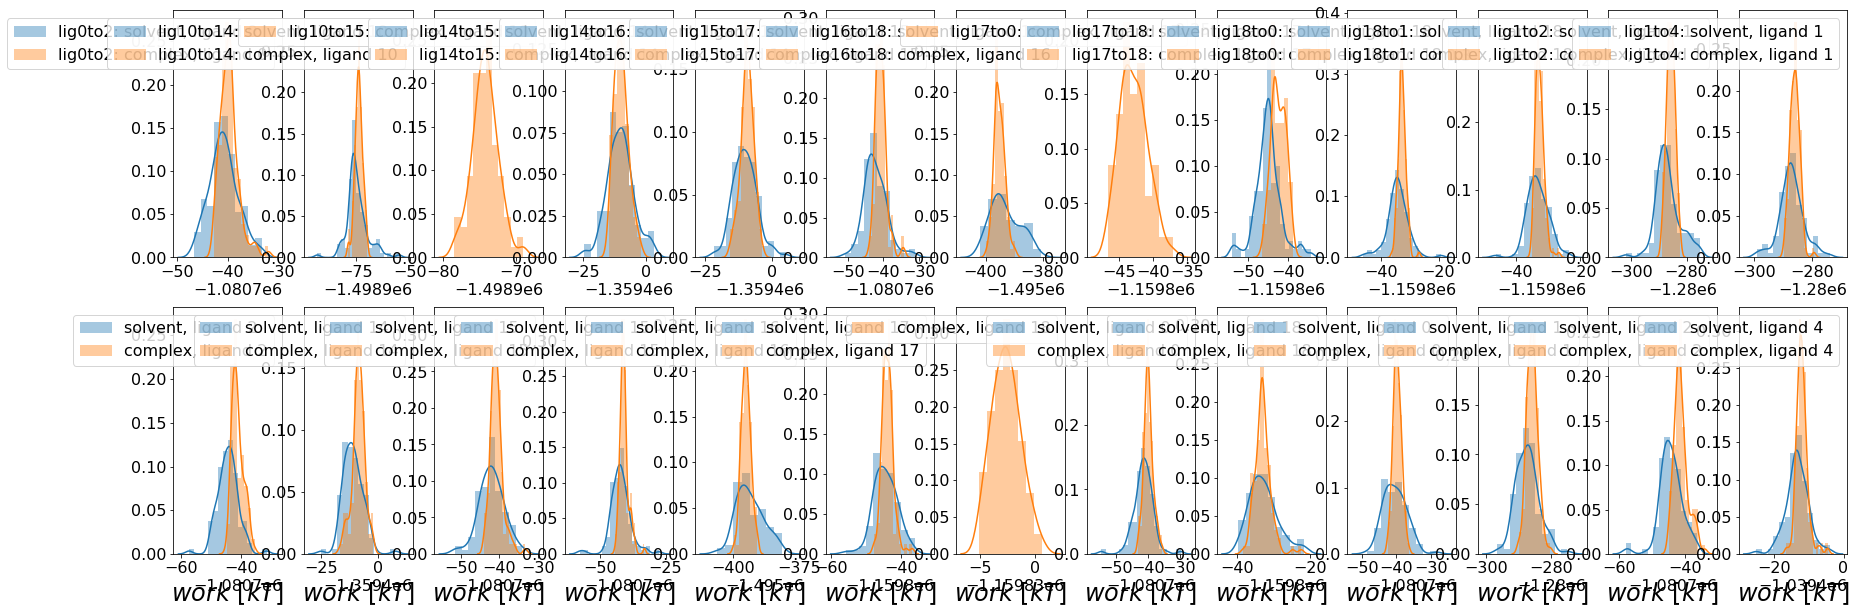

In [58]:
fig = plt.figure(figsize=(30, 10))
cols = len(list(grand_works_dict.keys()))
axes = fig.subplots(nrows=2, ncols=cols)
master_work_arrays = {}
for _idx, key in enumerate(list(grand_works_dict.keys())):
    _dict = grand_works_dict[key]
    xlims_low = []; xlims_high = []
    data_reserves = {}
    for __idx, coll in enumerate([('solvent', 'old'), ('solvent', 'new'), ('complex', 'old'), ('complex', 'new')]):
        try:
            if __idx==0:
                label = f"{key}: {coll[0]}, {coll[1]}"
            else:
                label = f"{coll[0]}, {coll[1]}"
                
            _data = np.array([val[-1] for val in _dict[f'{coll[0]}.1000.{coll[1]}'].values()])
            data_reserves[coll] = _data
        except Exception as e:
            print(e)
    
    tup = key.split('to')
    mod_tup = (int(tup[0][3:]), int(tup[1]))
    master_work_arrays[mod_tup] = data_reserves
            
    "now we plot the data"
    res = [int(i) for i in key[3:].split('to') if i.isdigit()]
    print(res)
    
    #row 0: old
    _axis = axes[0, _idx]
    try:
        sns.distplot(data_reserves[('solvent', 'old')], label = f"{key}: solvent, ligand {res[0]}", ax = _axis, color = default_color_cycle[0])
    except:
        pass
    
    try:
        sns.distplot(data_reserves[('complex', 'old')], label = f"{key}: complex, ligand {res[0]}", ax = _axis, color = default_color_cycle[1])
    except:
        pass
    
    _axis.legend()
    
    #row 1: new
    _axis = axes[1, _idx]
    try:
        sns.distplot(data_reserves[('solvent', 'new')], label = f"solvent, ligand {res[1]}", ax = _axis, color = default_color_cycle[0])
    except:
        pass
    
    try:
        sns.distplot(data_reserves[('complex', 'new')], ax = _axis, label = f"complex, ligand {res[1]}", color = default_color_cycle[1])
    except:
        pass
    
    _axis.set_xlabel(f"$work$ $[kT]$")
    
    _axis.legend(loc = 1)
    
    
#     print(f"{_idx}")
        
#     _min = min(xlims_low)
#     _max = max(xlims_high)
#     print(_min, _max)
#     for _row in range(4):
#         axes[_row, _idx].set_xlim(_min - 2, _max + 2)

    
plt.tight_layout()
#    grand_works_dict['lig0to2']['solvent.1000.new']

In [75]:
calculated = [] #each entry is a tuple of (perses_mm, perses_ani_corrected, perses_mm_ddg, perses_ani_corrected_ddg)
experimental = []
for ligpair in perses_dgs.keys():
    print(ligpair)
    try:
        _dict = master_work_arrays[ligpair]
        solvent_old_works, solvent_new_works, complex_old_works, complex_new_works = _dict[('solvent', 'old')], _dict[('solvent', 'new')], _dict[('complex', 'old')], _dict[('complex', 'new')]
        dg_mm, ddg_mm = perses_dgs[ligpair][:2]
        ani_corrected, ani_corrected_stddev = compute_ani_correction(solvent_old_works, solvent_new_works, complex_old_works, complex_new_works, dg_mm, ddg_mm)
        _experimental = experimental_dgs[ligpair]

        calculated.append((ligpair, dg_mm, ani_corrected, ddg_mm, ani_corrected_stddev))
        experimental.append((ligpair, _experimental))
    except Exception as e:
        print(f"exception: {e}")
        
        
print(f"experimental: {experimental}")
print(f"calculated: {calculated}")
    
    
    

(1, 4)
(17, 18)
(14, 16)
(5, 6)
exception: (5, 6)
(17, 0)
exception: ('solvent', 'old')
(9, 14)
exception: (9, 14)
(10, 15)
exception: ('solvent', 'old')
(5, 9)
exception: (5, 9)
(4, 5)
exception: (4, 5)
(10, 14)
(14, 15)
(15, 17)
(16, 18)
exception: ('solvent', 'new')
(9, 10)
exception: (9, 10)
(4, 6)
exception: (4, 6)
(2, 5)
exception: (2, 5)
(2, 4)
exception: (2, 4)
(0, 2)
(18, 0)
(1, 2)
(18, 1)
experimental: [((1, 4), -1.4998609999999992), ((17, 18), -0.330585000000001), ((14, 16), 0.041326999999999), ((10, 14), -0.4422940000000004), ((14, 15), -0.5570389999999996), ((15, 17), 0.27146199999999965), ((0, 2), 0.028821999999999903), ((18, 0), -0.4094660000000001), ((1, 2), -1.2906390000000005), ((18, 1), 0.9099950000000003)]
calculated: [((1, 4), -2.392463233677141, -1.4347759884609204, 0.08474060976396518, 2.051989994229122), ((17, 18), -0.6793224381026626, 7.498552353566065, 0.07885683502377334, 1.2851838732705358), ((14, 16), 0.8150939707842966, 1.1118458722916742, 0.09112272074350

In [67]:
def compute_ani_correction(solvent_old_works, solvent_new_works, complex_old_works, complex_new_works, dg_mm, ddg_mm):
    """
    given these 4 reduced work arrays and pre-computed dg_mm, ddg_mm, compute ANI-corrected relative free energy 
    NOTE : the work arrays are reduced (kT), whilst the dg_mm, and ddg_mm are in kcal/mol
    
    #after much struggle, the correction to the free energy is: dg_MM + (dg_complex_old - dg_solvent_old) - (dg_complex_new - dg_solvent_new)
    """
    from pymbar import EXP
    ckn = 0.593
    dg_complex_old, ddg_complex_old = np.array(EXP(complex_old_works)) / ckn
    dg_complex_new, ddg_complex_new = np.array(EXP(complex_new_works))/ ckn
    dg_solvent_old, ddg_solvent_old = np.array(EXP(solvent_old_works)) / ckn
    dg_solvent_new, ddg_solvent_new = np.array(EXP(solvent_new_works)) / ckn

    
    correction = dg_mm + (dg_complex_old -dg_solvent_old) - (dg_complex_new - dg_solvent_new)
    std_dev_correction = (ddg_complex_old**2 + ddg_complex_new**2 + ddg_solvent_old**2 + ddg_solvent_new**2 + ddg_mm**2)**(0.5)
    return correction, std_dev_correction
    
    
    
    
    

In [78]:
experimental[0][1]

-1.4998609999999992

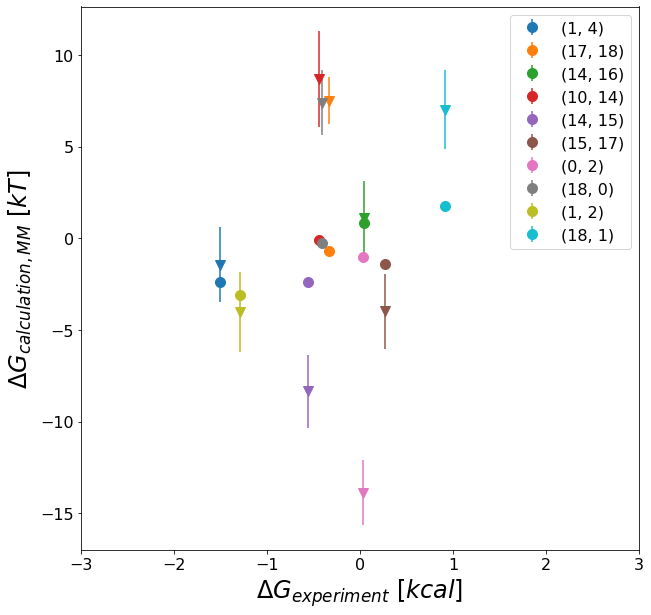

In [89]:
fig = plt.figure(figsize=(10, 10))
##first is just perses and calculated
perses_mm = [i[1] for i in calculated]
perses_mm_ddg = [i[3] for i in calculated]
ani_corrected = [i[2] for i in calculated]
ani_ddg = [i[4] for i in calculated]
for q in range(len(perses_mm)):
    plt.errorbar(experimental[q][1], calculated[q][1], yerr = calculated[q][3], label = f"{calculated[q][0]}", linestyle = 'None', ms = 10., marker = 'o', color = default_color_cycle[q])
    plt.errorbar(experimental[q][1], calculated[q][2], yerr = calculated[q][4], linestyle = 'None', marker = 'v', ms=10)
#slope, intercept, rval, pval, stderr = linregress(calcs, perses)
#space = np.linspace(min(calcs), max(calcs), 100)
#plt.plot(space, space*slope + intercept)
plt.xlim(-3, 3)
#plt.ylim(-3, 3)
plt.xlabel('$\Delta G_{experiment}$ $[kcal]$')
plt.ylabel('$\Delta G_{calculation, MM}$ $[kT]$')
plt.legend(loc = 1)

In [ ]:
a, b = np.array([1., 2.])/0.593

In [ ]:
q = np.array([])
not q

In [ ]:
st = 'lig10to14'
a = st.split('to')
a

In [ ]:
res = [int(i) for i in st.split() if i.isdigit()]

In [ ]:
res

for sanity check, let's plot the work distribution as a function of annealing time; i specifically want to plot the work distribution as a function of annealing time for lig0to2 complex and solvent (old or new)

In [ ]:
works_dict.keys()

In [ ]:
onek_solvent_data = master_work_arrays[(0,2)][('solvent', 'new')]
onek_complex_data = master_work_arrays[(0,2)][('complex', 'new')]

In [ ]:
len(grand_works_dict['lig0to2']['solvent.1000.new'][0])

In [ ]:
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(nrows=1, ncols=2)

#ax 0
sns.distplot([val[-1] for val in works_dict['solvent.1.new'].values()], label = f'solvent: 1 step', ax=axes[0])
sns.distplot([val[-1] for val in works_dict['solvent.500.new'].values()], label = f'solvent: 500 steps', ax=axes[0])
sns.distplot(onek_solvent_data, label = 'solvent: 1000 steps', ax=axes[0])
axes[0].legend()
axes[0].set_xlabel("$work$ $[kT]$")
axes[0].set_ylabel("$p(work)$")
axes[0].set_ylim(0., 0.3)
axes[1].set_ylim(0., 0.3)

# ax 1
sns.distplot([val[-1] for val in works_dict['complex.1.new'].values()], label = f'complex: 1 step', ax=axes[1])
sns.distplot([val[-1] for val in works_dict['complex.500.new'].values()], label = f'complex: 500 steps', ax=axes[1])
sns.distplot(onek_complex_data, label = 'complex: 1000 steps', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel("$work$ $[kT]$")

#axes[0].set_ylabel("$p(work)$")
plt.tight_layout()

the last sanity check is that for some transforms (e.g. lig0to2, lig8to2, the 'complex/solvent' 'new' should have nearly identical work histograms since they are computing the same free energies)...let's see if this is true

In [ ]:
master_work_arrays.keys() #print all of the transformations we have

In [ ]:
master_work_arrays[(0,2)].keys() #what are the entries to these, again?

In [ ]:
#ah, that's right

In [ ]:
#return the transforms if the old/new indices are the same:
def remove_duplicates(x):
    from itertools import groupby
    return [k for k, v in groupby(sorted(x))]

transform_keys = list(master_work_arrays.keys() )
all_olds = [trans[0] for trans in transform_keys]
all_news = [trans[1] for trans in transform_keys]
all_old_matches = [[trans for trans in transform_keys if trans[0] == q] for q in all_olds]
all_new_matches = [[trans for trans in transform_keys if trans[1] == q] for q in all_news]
all_old_matches = remove_duplicates([old_match  for old_match in all_old_matches if len(old_match) > 1])
all_new_matches = remove_duplicates([new_match for new_match in all_new_matches if len(new_match) > 1])
#wow, there's certainly an easier way of doing this...

In [ ]:
all_new_matches

In [ ]:
#all old matches, solvent
fig = plt.figure(figsize=(20,10))
idx=1
for entry in all_old_matches:
    solvent_data = []
    for q in entry:
        try:
            solvent_data.append(master_work_arrays[q][('solvent', 'old')])
        except Exception as e:
            print(e)
    
    if len(solvent_data) > 1:
        ax = plt.subplot(2,len(all_old_matches),idx)
        idx+=1
        for subidx, _e in enumerate(solvent_data):
            sns.distplot(_e, ax=ax, color = default_color_cycle[0])
            ax.set_title(f"ligand {entry[0][0]}")
        ax.set_xlabel(f"$work$ $[kT]$")
    if idx==2:
        ax.set_ylabel(f"$p(work)$")
        
plt.tight_layout()

In [ ]:
#all old matches, complex
fig = plt.figure(figsize=(20,10))
idx=1
for entry in all_old_matches:
    solvent_data = []
    for q in entry:
        try:
            solvent_data.append(master_work_arrays[q][('complex', 'old')])
        except Exception as e:
            print(e)
    
    if len(solvent_data) > 1:
        ax = plt.subplot(2,len(all_old_matches),idx)
        idx+=1
        for subidx, _e in enumerate(solvent_data):
            sns.distplot(_e, ax=ax, color = default_color_cycle[0])
            ax.set_title(f"ligand {entry[0][0]}")
        ax.set_xlabel(f"$work$ $[kT]$")
    if idx==2:
        ax.set_ylabel(f"$p(work)$")
        
plt.tight_layout()

In [ ]:
#all new matches, solvent
fig = plt.figure(figsize=(20,10))
idx=1
for entry in all_new_matches:
    solvent_data = []
    for q in entry:
        try:
            solvent_data.append(master_work_arrays[q][('solvent', 'new')])
        except Exception as e:
            print(e)
    
    if len(solvent_data) > 1:
        ax = plt.subplot(2,len(all_new_matches),idx)
        idx+=1
        for subidx, _e in enumerate(solvent_data):
            sns.distplot(_e, ax=ax, color = default_color_cycle[0])
            ax.set_title(f"ligand {entry[0][1]}")
        ax.set_xlabel(f"$work$ $[kT]$")
    if idx==2:
        ax.set_ylabel(f"$p(work)$")
        
plt.tight_layout()

In [ ]:
#all new matches, complex
fig = plt.figure(figsize=(20,10))
idx=1
for entry in all_new_matches:
    solvent_data = []
    for q in entry:
        try:
            solvent_data.append(master_work_arrays[q][('complex', 'new')])
        except Exception as e:
            print(e)
    
    if len(solvent_data) > 1:
        ax = plt.subplot(2,len(all_new_matches),idx)
        idx+=1
        for subidx, _e in enumerate(solvent_data):
            sns.distplot(_e, ax=ax, color = default_color_cycle[0])
            ax.set_title(f"ligand {entry[0][1]}")
        ax.set_xlabel(f"$work$ $[kT]$")
    if idx==2:
        ax.set_ylabel(f"$p(work)$")
        
plt.tight_layout()

In [ ]:
#solvent
fig = plt.figure(figsize=(5,5))
axes = fig.subplots(nrows=1, ncols=3)
old_matches = [item for item in all_old_matches if item[0][0] in [1, 14, 18]]

for col in range(len(old_matches)):
    try:
        solvent_data = [master_work_arrays[transform][('solvent', 'old')] for transform in old_matches[col]]
        for entry in solvent_data:
            sns.distplot(entry, ax = axes[col], color = default_color_cycle[0])
        axes[col].set_title(f"ligand {all_old_matches[col][0][0]}")
        axes[col].set_xlabel(f"$work$ $[kT]$")
        if col==0:
            axes[col].set_ylabel(f"$p(work)$")
    except Exception as e:
        print(e)
        continue

plt.tight_layout()

In [ ]:
#complex
fig = plt.figure(figsize=(5*3,5))
axes = fig.subplots(nrows=1, ncols=3)
old_matches = [item for item in all_old_matches if item[0][0] in [1, 14, 18]]

for col in range(len(old_matches)):
    try:
        solvent_data = [master_work_arrays[transform][('complex', 'old')] for transform in old_matches[col]]
        for entry in solvent_data:
            sns.distplot(entry, ax = axes[col], color = default_color_cycle[0])
        axes[col].set_title(f"ligand {all_old_matches[col][0][0]}")
        axes[col].set_xlabel(f"$work$ $[kT]$")
        if col==0:
            axes[col].set_ylabel(f"$p(work)$")
    except Exception as e:
        print(e)
        continue

plt.tight_layout()

In [ ]:
np.save(f"full_data_dict.npy", master_work_arrays) #need to save a notebook of all these data
